In [1]:
import cooler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import os
import joblib
import glob
from scipy.stats import zscore, pearsonr, norm

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [2]:
def find_close_numbers(numbers, threshold):
    close_number_groups = []
    current_group = [numbers[0]]

    for i in range(1, len(numbers)):
        if numbers[i] - numbers[i - 1] <= threshold:
            current_group.append(numbers[i])
        else:
            close_number_groups.append(current_group)
            current_group = [numbers[i]]

    # Add the last group to the result
    close_number_groups.append(current_group)

    # Filter out groups with only one element
    close_number_groups = [group for group in close_number_groups if len(group) > 1]

    return close_number_groups

In [3]:
file_dir = 'Call.DiffComp.CellType.Age/'

outdir = os.getcwd()
res = 100000
chrom_size_path = '/ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)

In [4]:
_dir = '/home/qzeng_salk_edu/project/240204-redo-compartment'
cpg = pd.read_hdf(f'{_dir}/cpg_ratio_100k.hdf')
cpg.head()

chrom   start     end  cpg_ratio
0  chr1       0  100000        0.0
1  chr1  100000  200000        0.0
2  chr1  200000  300000        0.0
3  chr1  300000  400000        0.0
4  chr1  400000  500000        0.0

## find cts

In [5]:
all_results = glob.glob(f'{file_dir}/*/DifferentialResult/fdr_result')

In [6]:
all_cts = [path.split('/')[1] for path in all_results]

In [7]:
pvalue_cutoff = 0.05
for ct in all_cts:
    path = f'{file_dir}/{ct}/DifferentialResult/fdr_result/differential.intra_sample_combined.pcQnm.bedGraph'
    
    comp =pd.read_csv(path, sep='\t', header=0, index_col=None)
    comp.index = comp['chr'] + '_' + (comp['start'] // res).astype(str)
    comp = comp[comp['chr'] != 'chrX']
    comp = comp[comp['padj'] < pvalue_cutoff]
    #selb = zscore(comp['sample_maha'])>norm.isf(0.025)
    #comp = comp.loc[selb]
    

    for _chr, tmpdf in comp.groupby('chr'):
        all_chrom_100k = tmpdf.index
        chunk_numbers = [int(chunk_id.split('_')[1]) for chunk_id in all_chrom_100k]
        result = find_close_numbers(chunk_numbers, 5)
        for chunk in result:
            if len(chunk) >= 10:
                print(f"{ct} {_chr} {chunk}")
        

Oligo_NN chr2 [716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728]
Oligo_NN chr2 [739, 740, 741, 742, 744, 746, 751, 752, 753, 754]
Oligo_NN chr2 [1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1723, 1725, 1726, 1727, 1728]
Oligo_NN chr4 [1525, 1526, 1527, 1528, 1529, 1530, 1534, 1535, 1536, 1537, 1538]
Oligo_NN chr9 [337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 349, 352]
DG-PIR_Ex_IMN chr1 [411, 412, 413, 414, 415, 416, 417, 419, 422, 424]
DG-PIR_Ex_IMN chr1 [756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 773, 774, 775, 776, 778, 781]
DG-PIR_Ex_IMN chr10 [128, 129, 134, 135, 136, 137, 138, 139, 141, 142]
DG-PIR_Ex_IMN chr10 [913, 914, 915, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928]
DG-PIR_Ex_IMN chr11 [1120, 1121, 1124, 1128, 1131, 1132, 1133, 1134, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145]
DG-PIR_Ex_IMN chr12 [265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276

## check diff result

In [8]:
ct = 'Oligo_NN'
binall = joblib.load(f'{file_dir}/{ct}/binfilter_raw.npy')

In [9]:
#pvalue_cutoff = 0.05
path = f'{file_dir}/{ct}/DifferentialResult/fdr_result/differential.intra_sample_combined.pcQnm.bedGraph'

In [10]:
comp =pd.read_csv(path, sep='\t', header=0, index_col=None)
comp.index = comp['chr'] + '_' + (comp['start'] // res).astype(str)
comp = comp[comp['chr'] != 'chrX']
#comp = comp[comp['padj'] < pvalue_cutoff]
selb = zscore(comp['sample_maha'])>norm.isf(0.025)
comp = comp.loc[selb]

In [11]:
chr_diff_comp = {}
for _chr, tmpdf in comp.groupby('chr'):
    all_chrom_100k = tmpdf.index
    chunk_numbers = [int(chunk_id.split('_')[1]) for chunk_id in all_chrom_100k]
    result = find_close_numbers(chunk_numbers, 10)
    chr_diff_comp[_chr] = result

## plot example

In [12]:
num = 2
chrom = f'chr{num}'
binfilter = binall[num-1]
n_bins = (int(chrom_sizes.loc[chrom]) // res + 1)
n_bins

1822

In [13]:
Qall = []
leg = []
indir = '/data/female-amb/CellType.Age.Merged.mcool'
for sample_name in [f'{ct}.8wk',f'{ct}.9mo',f'{ct}.18mo']:
    #cool = cooler.Cooler(f'{indir}/{sample_name}.raw.mcool::resolutions/100000')
    cool = cooler.Cooler(f'/data/female-amb/impute/merged-100k/{sample_name}.Q.cool')
    Q = cool.matrix(balance=False, sparse=True).fetch(chrom).toarray()
    Q = Q - np.diag(np.diag(Q))
    rowsum = Q.sum(axis=0)
    # thres = np.percentile(rowsum[rowsum>0], 50) * 2 - np.percentile(rowsum[rowsum>0], 99)
    # binfilter = (rowsum>thres)
    # binall.append(binfilter)
    Q = Q[binfilter][:, binfilter]
    Qall.append(Q)
    leg.append(sample_name)

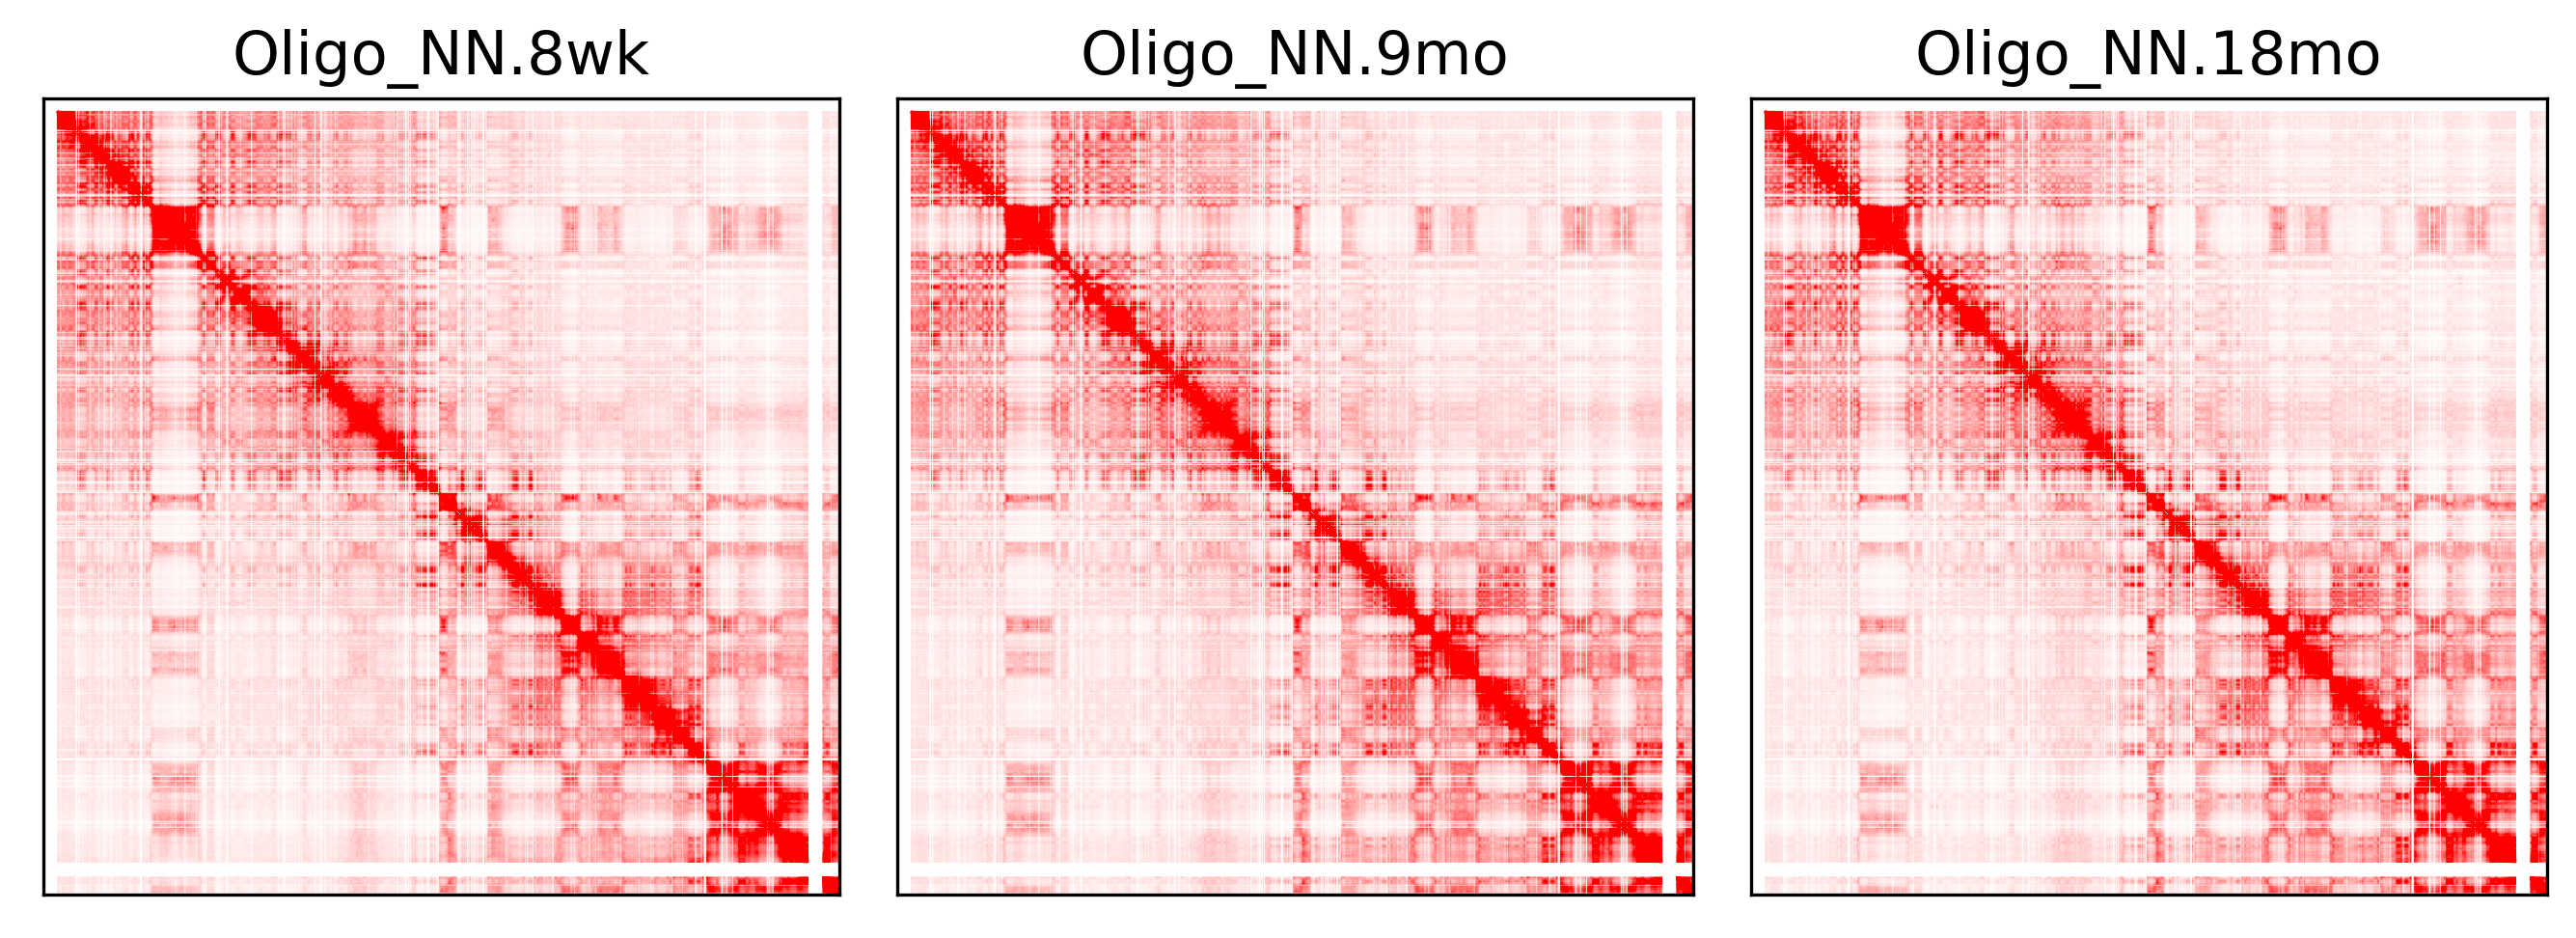

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(3*len(leg),4), dpi = 300)
#fig, axes = plt.subplots(2, len(leg), figsize=(3*len(leg),4), gridspec_kw={'height_ratios':[4,0.5]}, sharex='col', sharey='row')
for i in range(len(leg)):
    ax = axes[i]
    tmp = np.zeros((n_bins, n_bins))
    tmp[np.ix_(binfilter, binfilter)] = Qall[i]
    ax.imshow(tmp, cmap='bwr', vmin=-0.0015, vmax=0.0015, rasterized = True) #-40,40
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(leg[i], fontsize=15)

plt.tight_layout()
#plt.savefig(f'figure/{chrom}.celltype_Q.pdf', transparent=True)

In [15]:
comp = pd.read_hdf(f'{file_dir}/{ct}/raw_{ct}_celltyperawpca.hdf', key='data')

Call = []
pcall = []
for k,ct_age in enumerate(leg):
    Q = Qall[k].copy()
    decay = np.array([np.mean(np.diag(Q, i)) for i in range(Q.shape[0])])
    E = np.zeros(Q.shape)
    row, col = np.diag_indices(E.shape[0])
    E[row, col] = 1
    for i in range(1, E.shape[0]):
        E[row[:-i], col[i:]] = (Q[row[:-i], col[i:]] + 1e-5) / (decay[i] + 1e-5)
    E = E + E.T
    C = np.corrcoef(np.log2(E + 0.001))
    Call.append(C)
    tmp = comp.loc[(comp.index.str.split('-').str[0]==chrom), ct_age]
    tmp.index = [int(xx.split('-')[1]) for xx in tmp.index]
    pcall.append(tmp[np.where(binfilter)[0]].values)
    print(ct_age)

Oligo_NN.8wk
Oligo_NN.9mo
Oligo_NN.18mo


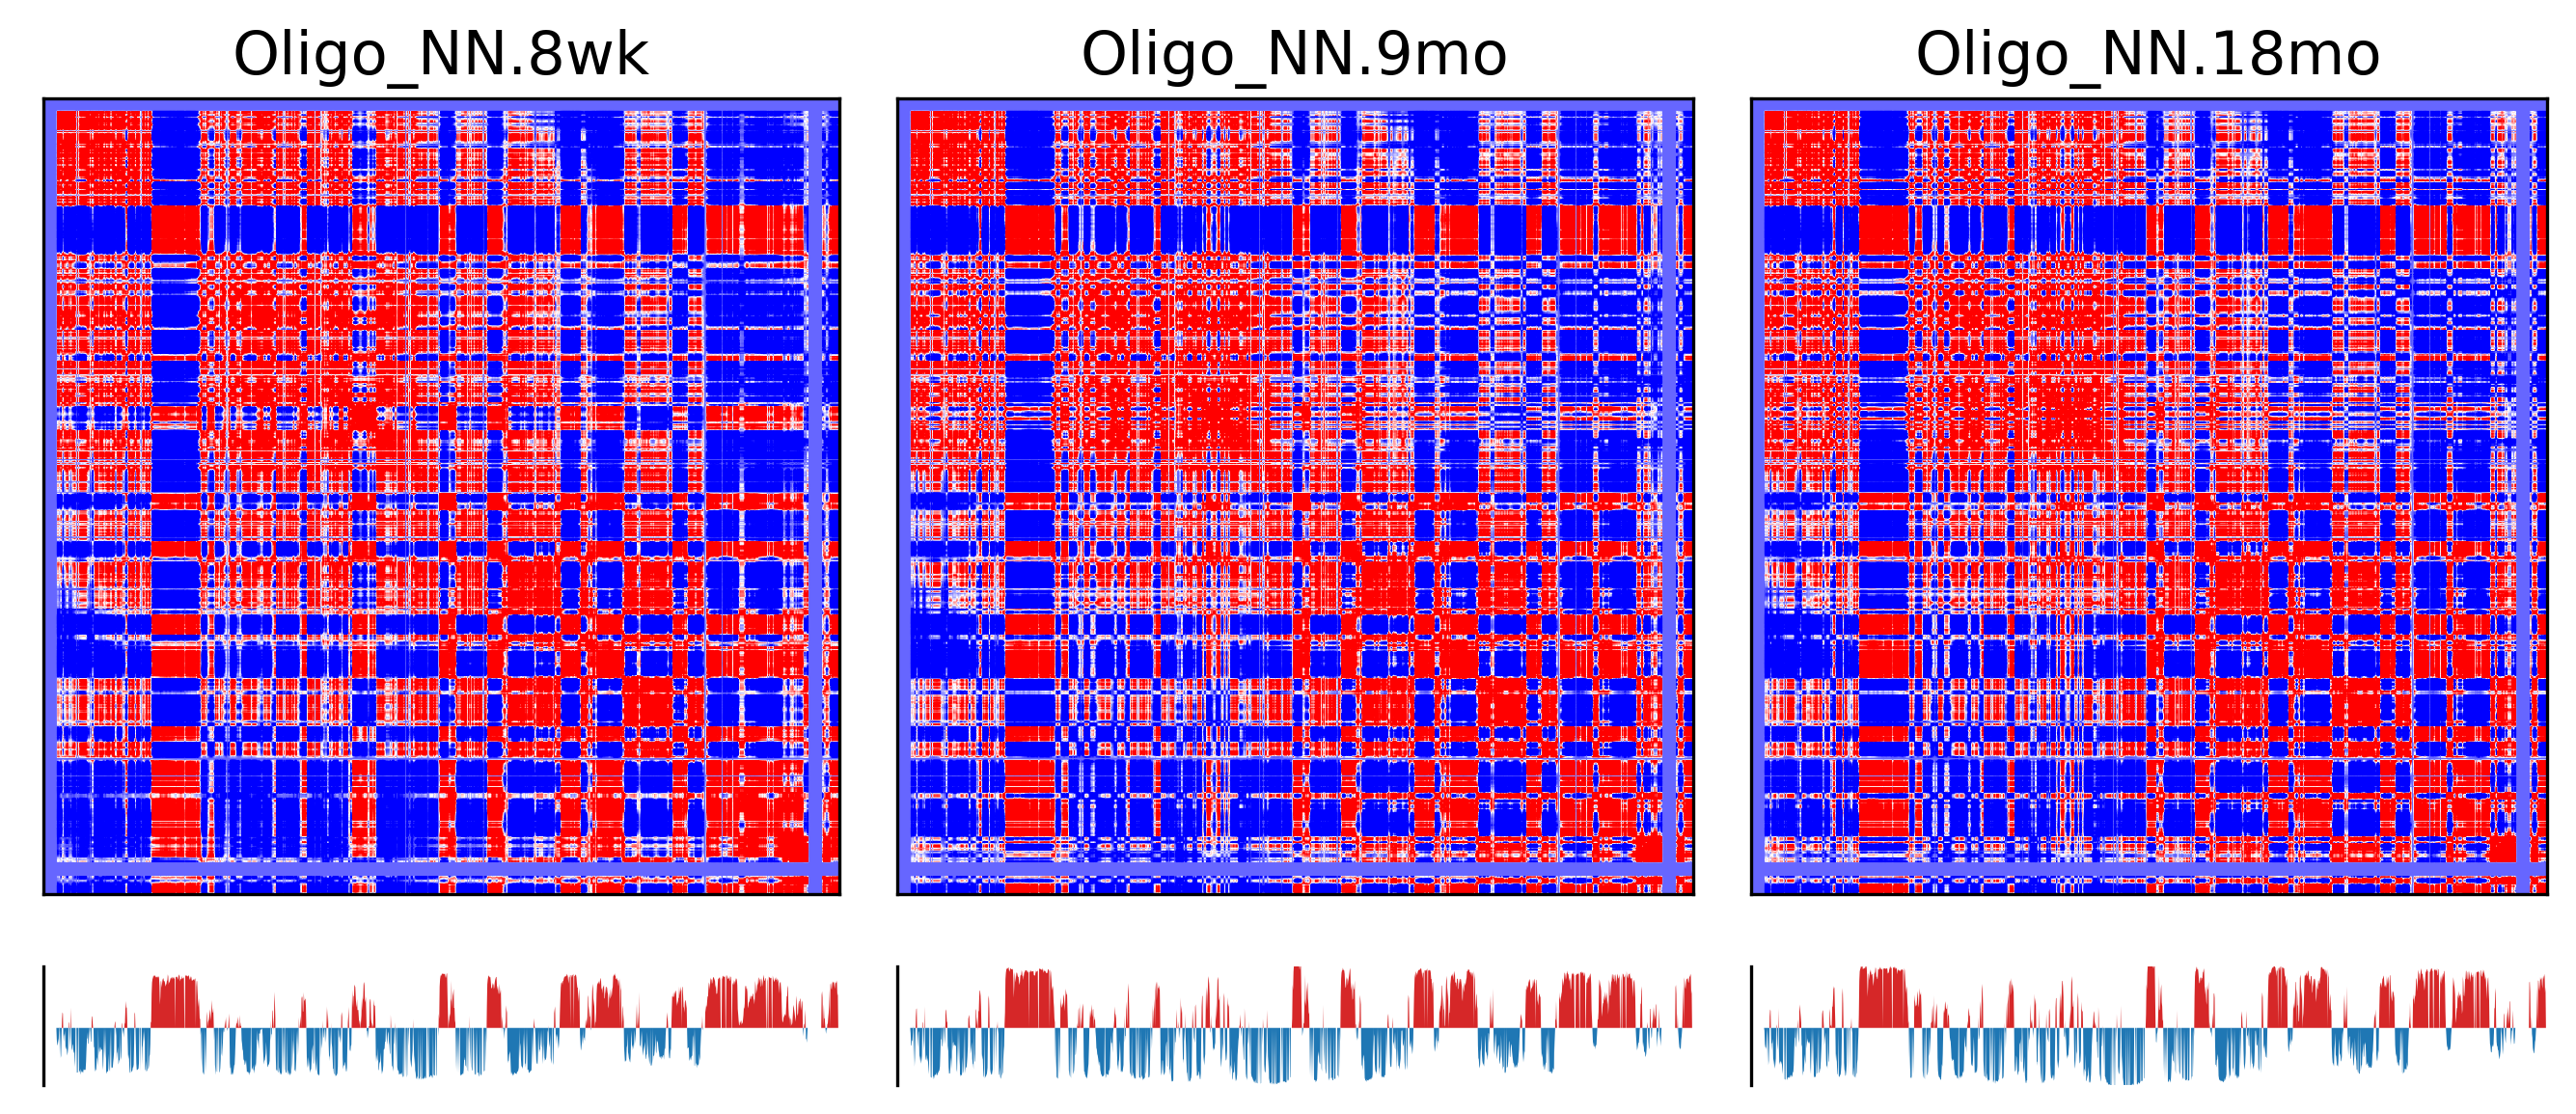

In [16]:
fig, axes = plt.subplots(2, len(leg), dpi = 300,figsize=(3*len(leg),4), gridspec_kw={'height_ratios':[4,0.5]}, sharex='col', sharey='row')
for i in range(3):
    ax = axes[0,i]
    tmp = np.zeros((n_bins, n_bins))
    tmp[np.ix_(binfilter, binfilter)] = Call[i]
    ax.imshow(tmp, cmap='bwr', vmin=-0.1, vmax=0.4,rasterized = True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(leg[i], fontsize=15)

    ax = axes[1,i]
    # ax.set_title('PC1', fontsize=10)
    sns.despine(bottom=True, ax=ax)
    tmp = np.zeros(n_bins)
    tmp[binfilter] = pcall[i]# / np.std(pcall[i])
    x, y = np.arange(n_bins), tmp
    # x, y = np.arange(pcall[i].shape[0]), pcall[i]
    ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
    ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
    ax.set_yticks([-15, 15])
    ax.set_ylim([np.percentile(y, 1), np.percentile(y, 99)])

plt.tight_layout()
#plt.savefig(f'figure/{chrom}.celltype_Q_compartment.pdf', transparent=True)

## plot diff comp

In [17]:
num = 2
chrom = f'chr{num}'
binfilter = binall[num-1]
n_bins = (int(chrom_sizes.loc[chrom]) // res + 1)
n_bins

1822

In [18]:
to_plot_bins = chr_diff_comp[chrom][3]
len(to_plot_bins)

24

In [19]:
binfilter_df = pd.Series(binfilter)
binfilter_df = binfilter_df[binfilter_df == True]
binfilter_id = binfilter_df.index.tolist()

In [20]:
slop_chunk = 10
diffc_l, diffc_r = to_plot_bins[0], to_plot_bins[-1]
ll, rr = diffc_l-slop_chunk,  diffc_r+slop_chunk
ll, rr

(1683, 1738)

In [36]:
print(f"{chrom}:{ll*res}-{rr*res}")

chr2:168300000-173800000


In [21]:
print(f"{chrom}:{diffc_l*res/1000000}M-{diffc_r*res/1000000}M")

chr2:169.3M-172.8M


In [23]:
Qall = []
leg = []
indir = '/data/female-amb/CellType.Age.Merged.mcool'
for sample_name in [f'{ct}.8wk',f'{ct}.9mo',f'{ct}.18mo']:
    #cool = cooler.Cooler(f'{indir}/{sample_name}.raw.mcool::resolutions/100000')
    cool = cooler.Cooler(f'/data/female-amb/impute/merged-100k/{sample_name}.Q.cool')
    Q = cool.matrix(balance=False, sparse=True).fetch(f"{chrom}:{ll*res}-{rr*res}").toarray()
    Q = Q - np.diag(np.diag(Q))
    rowsum = Q.sum(axis=0)
    
    Qall.append(Q)
    leg.append(sample_name)

In [24]:
#leg = [_.replace('-','_').replace('.','_') for _ in leg]

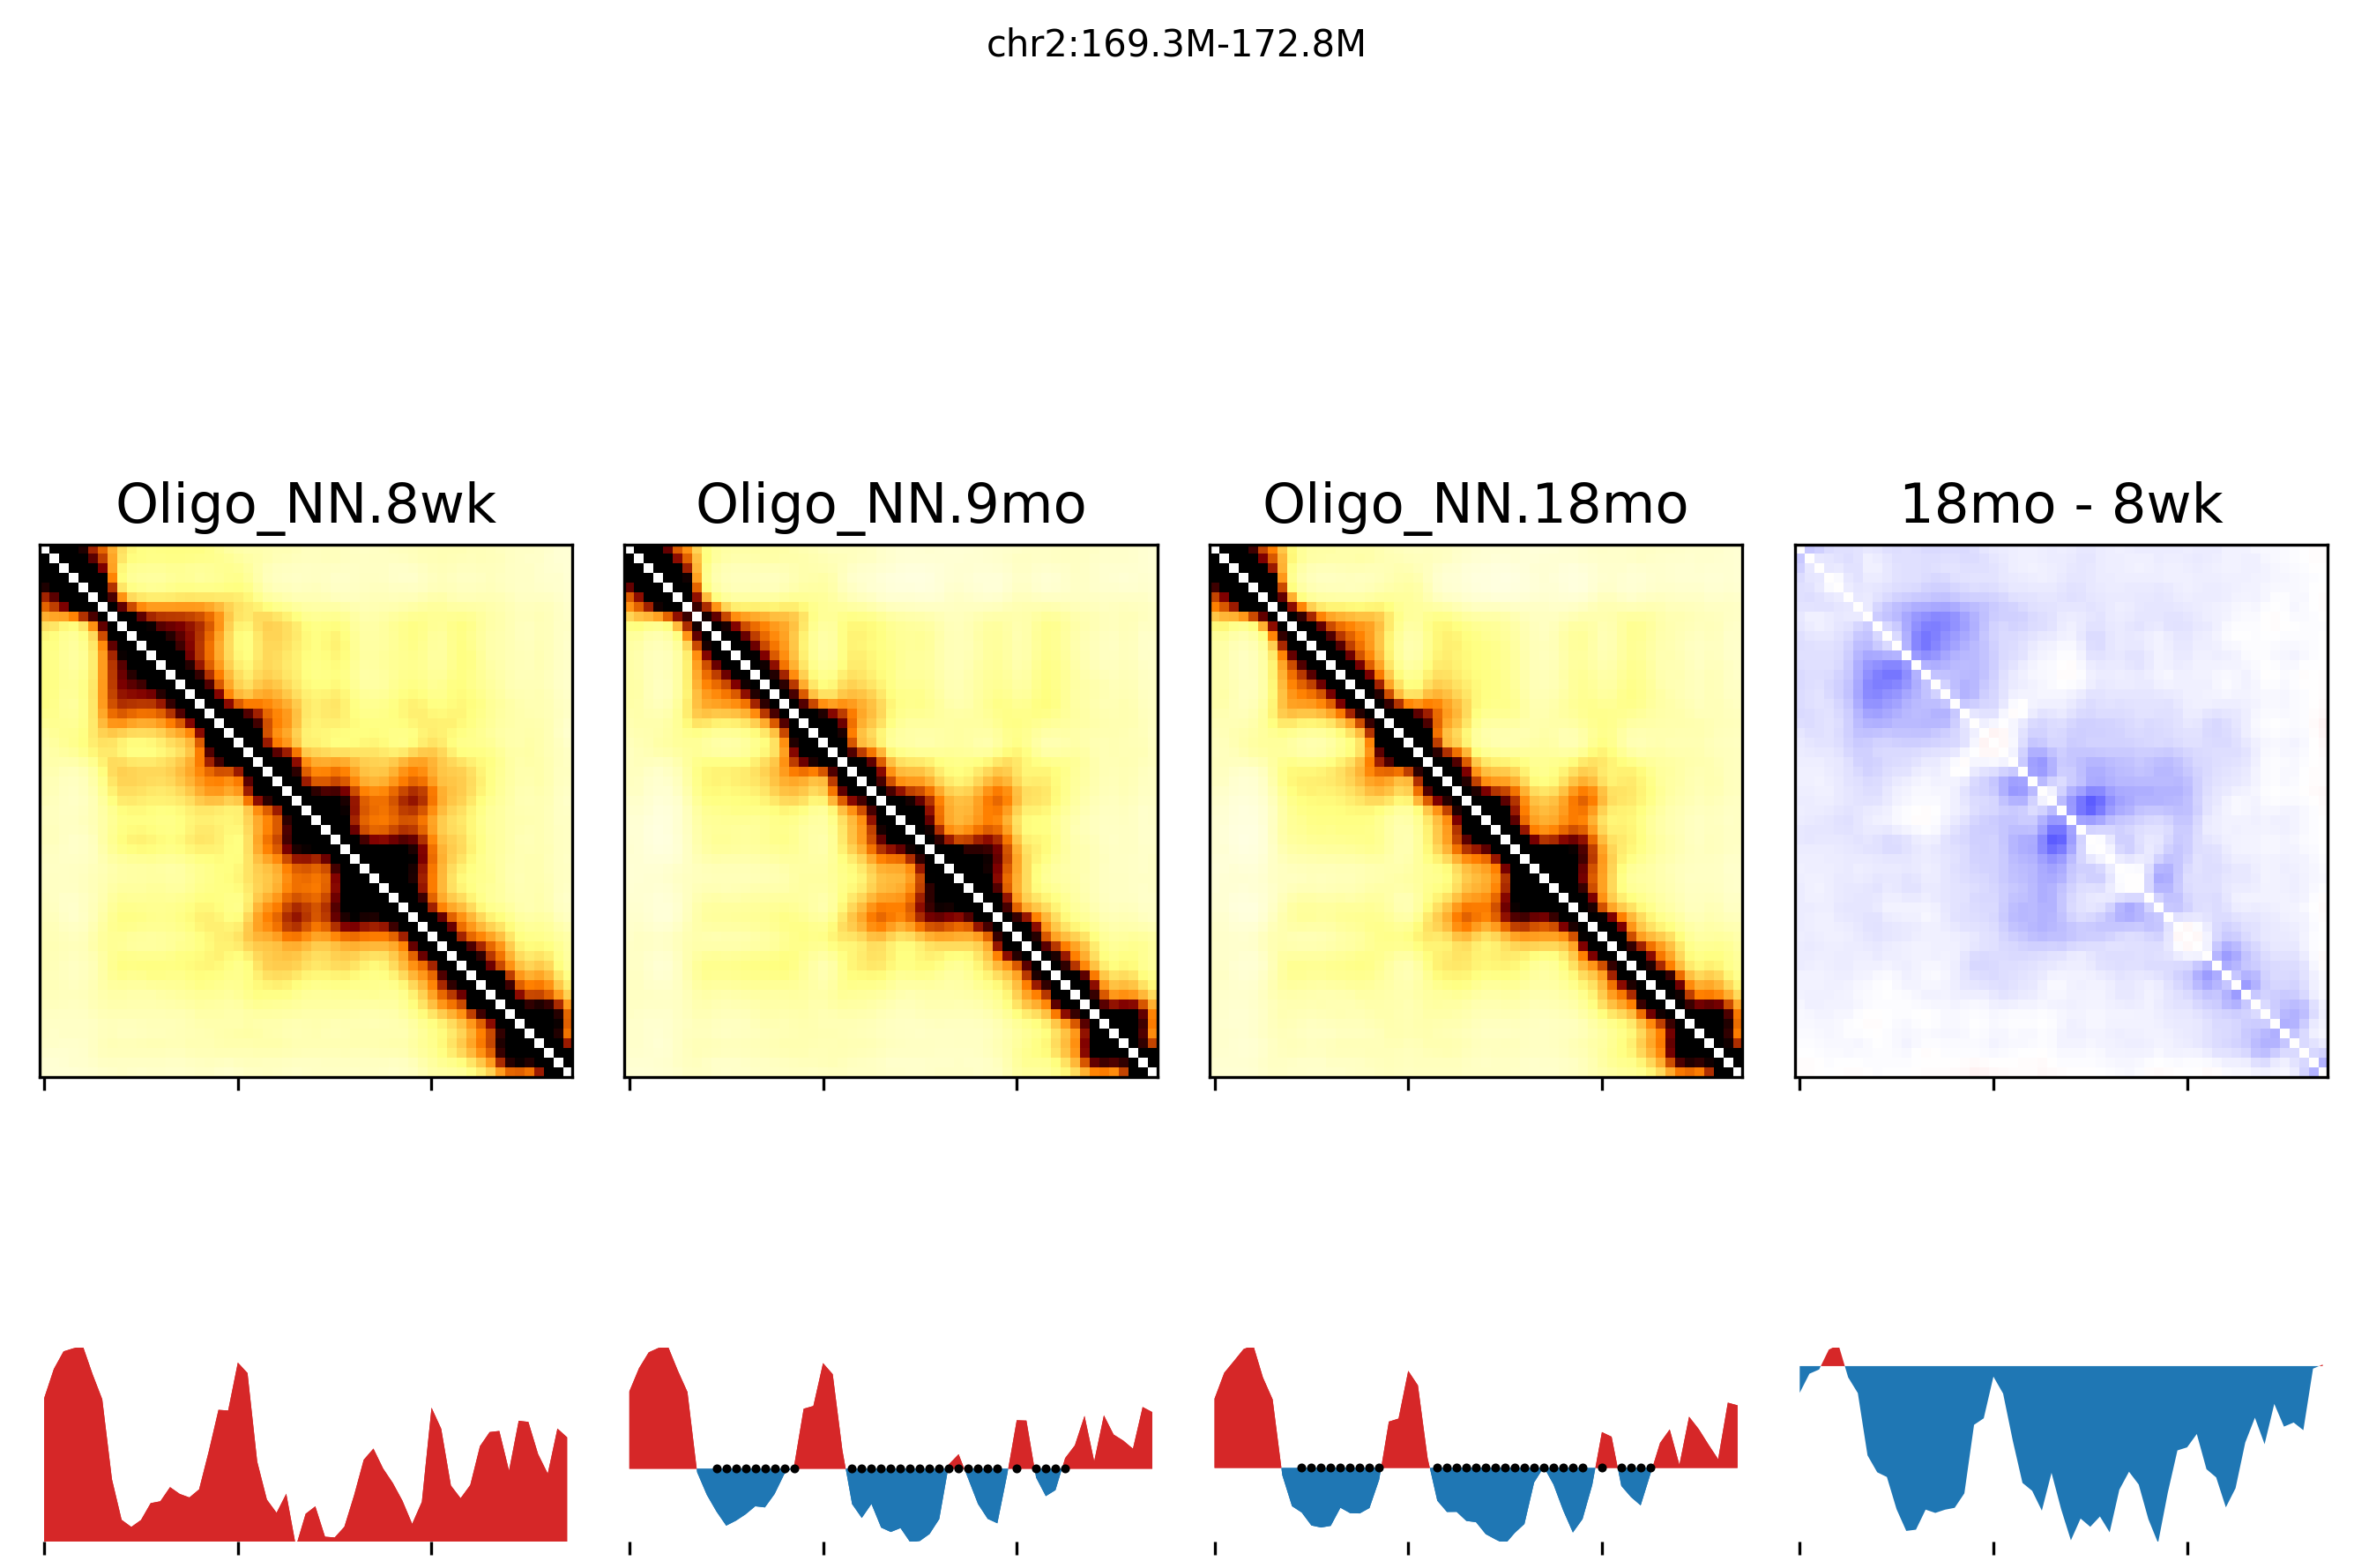

In [35]:
# identify diff c
comp = pd.read_csv(f'{file_dir}/{ct}/DifferentialResult/fdr_result/differential.intra_sample_combined.pcQnm.bedGraph', 
                   sep='\t', header=0, index_col=None)

comp.index = comp['chr'] + '_' + (comp['start'] // res).astype(str)
bincomp = comp[['chr', 'start', 'end', 'sample_maha', 'pval', 'padj']]

selc = (bincomp['chr']==chrom) & (bincomp['start']>=ll*res) & (bincomp['start']<rr*res) & (bincomp['padj']<0.05)
tmpc = bincomp.loc[selc, 'start'] // res - ll

fig, axes = plt.subplots(2, len(leg)+1, figsize=(3*len(leg),6), gridspec_kw={'height_ratios':[4,0.5]}, sharex='col', dpi = 300,) #sharey='row'#,'width_ratios':[1]*len(leg)
value = 0.015
for i in range(len(leg)):
    ax = axes[0,i]
    tmp = Qall[i]
    ax.imshow(tmp, cmap='afmhot_r',vmin=0, vmax=value,) 
    #ax.set_xticks([diffc_l, diffc_r])
    ax.set_xticklabels([])
    #ax.set_xticklabels(['TSS','TES'])
    ax.set_yticks([])
    ax.set_title(leg[i], fontsize=15)
    
    ax = axes[1,i]
    sns.despine(bottom=True, left=True, ax=ax)
    tmp = np.zeros(n_bins)
    #tmp = pcall[i]
    tmp[binfilter] = pcall[i]
    x, y = np.arange(rr-ll), tmp[ll:rr]
    ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
    ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
    ax.set_yticks([])
    ax.set_ylim([np.percentile(y, 1), np.percentile(y, 99)])
    
    ax = axes[1,i]
    sns.despine(bottom=True, left=True, ax=ax)
    tmp = np.zeros(n_bins)
    #tmp = pcall[i]
    tmp[binfilter] = pcall[i]
    x, y = np.arange(rr-ll), tmp[ll:rr]
    ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
    ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
    ax.scatter(tmpc, np.zeros(len(tmpc)), color='black', s=2)
    ax.set_yticks([])
    ax.set_ylim([np.percentile(y, 1), np.percentile(y, 99)])


ax = axes[0,3]
tmp = Qall[2] - Qall[0]
value_8wk_18mo = 0.008
ax.imshow(tmp, cmap='bwr',vmin=-value_8wk_18mo, vmax=value_8wk_18mo) 
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_title('18mo - 8wk', fontsize=15)

ax = axes[1,3]
sns.despine(bottom=True, left=True, ax=ax)
tmp = np.zeros(n_bins)
#tmp = pcall[i]
tmp[binfilter] = pcall[2] - pcall[0]
x, y = np.arange(rr-ll), tmp[ll:rr]
ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
ax.set_yticks([])
ax.set_ylim([np.percentile(y, 1), np.percentile(y, 99)])
    
plt.tight_layout()
plt.suptitle(f"{chrom}:{diffc_l*res/1000000}M-{diffc_r*res/1000000}M", fontsize=10)
fig.savefig(f'figure/{ct}.diff_c.example.pdf', transparent=True)

In [26]:
#ax.scatter(tmpc, np.zeros(len(tmpc)), color='r', s=4)

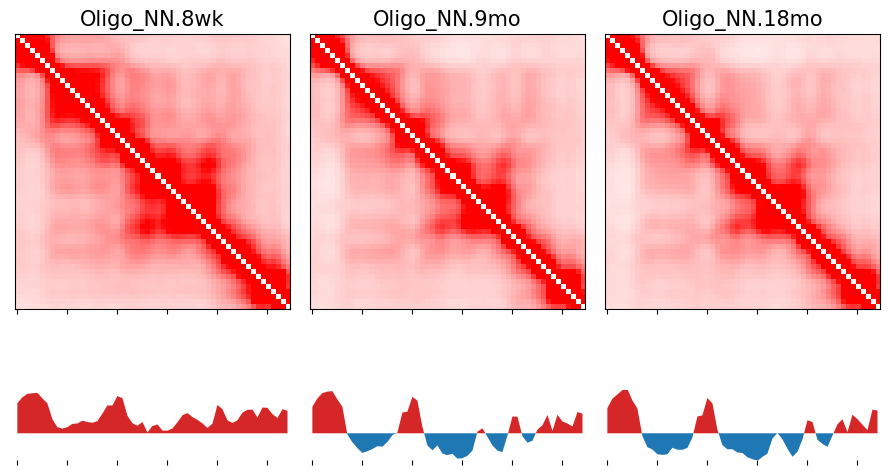

In [27]:
fig, axes = plt.subplots(2, len(leg), figsize=(3*len(leg),6), gridspec_kw={'height_ratios':[4,0.5]}, sharex='col', sharey='row') #,'width_ratios':[1]*len(leg)
value = 0.01
for i in range(len(leg)):
    ax = axes[0,i]
    tmp = Qall[i]
    ax.imshow(tmp, cmap='bwr',vmin=-value, vmax=value) 
    #ax.set_xticks([diffc_l, diffc_r])
    ax.set_xticklabels([])
    #ax.set_xticklabels(['TSS','TES'])
    ax.set_yticks([])
    ax.set_title(leg[i], fontsize=15)
    
    ax = axes[1,i]
    sns.despine(bottom=True, left=True, ax=ax)
    tmp = np.zeros(n_bins)
    #tmp = pcall[i]
    tmp[binfilter] = pcall[i]
    x, y = np.arange(rr-ll), tmp[ll:rr]
    ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
    ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
    ax.set_yticks([])
    ax.set_ylim([np.percentile(y, 1), np.percentile(y, 99)])

    
plt.tight_layout()